## Load module

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, Dataset

from sklearn.metrics import mean_squared_error, r2_score
import math

## Set parameter

In [3]:
path = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/monthly-car-sales.csv'
df = pd.read_csv(path, usecols=['Sales'])
n_train = int(len(df) * 0.8)
n_train

86

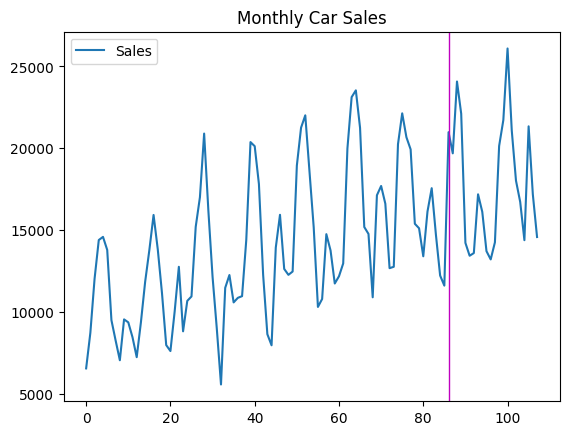

In [4]:
df.plot()
plt.axvline(n_train, c='m', lw=1.0)
plt.title('Monthly Car Sales')
plt.show()

## Prepare dataset

In [41]:
from sklearn.preprocessing import MinMaxScaler



# Reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Define nomalizer
# -------------------------------
# Scaling and sequence creation
# -------------------------------
scaler = MinMaxScaler(feature_range=(0, 1))
values = scaler.fit_transform(df[['Sales']].values.astype('float32'))


def create_sequences(series, step=1):
    X, y = [], []
    for i in range(len(series) - step):
        X.append(series[i:i+step])
        y.append(series[i+step])
    return np.array(X), np.array(y)

step = 3
X_all, y_all = create_sequences(values, step=step)
print("X_all shape:", X_all.shape, " y_all shape:", y_all.shape)

# -------------------------------
# Train/Validation/Test split
# -------------------------------
n_total = len(X_all)
n_train = int(n_total * 0.8)
X_train_full, y_train_full = X_all[:n_train], y_all[:n_train]
X_test, y_test = X_all[n_train:], y_all[n_train:]

n_val = max(1, int(len(X_train_full) * 0.1))
n_train_main = len(X_train_full) - n_val


class SeqDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X).float()
        self.y = torch.from_numpy(y).float()
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


full_ds = SeqDataset(X_train_full, y_train_full)
train_ds = SeqDataset(X_train_full[:n_train_main], y_train_full[:n_train_main])
val_ds = SeqDataset(X_train_full[n_train_main:], y_train_full[n_train_main:])
test_ds = SeqDataset(X_test, y_test)

batch_size = 4
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_ds, batch_size=batch_size, shuffle=False)

X_all shape: (105, 3, 1)  y_all shape: (105, 1)


## Create model

In [103]:
class LSTMRegressor(nn.Module):
    def __init__(self, input_size=1, hidden_size=32, num_layers=1):
        super().__init__()
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)
    def forward(self, x):
        # print("Input shape:", self.lstm(x[0]))
        # print("Type: ", type(self.lstm(x[0])[0]))
        # print(self.lstm(x[0])[0][0])
        out, _ = self.lstm(x[0])
        out = torch.relu(out)
        last = out[:, -1, :]
        return self.fc(last)

In [104]:
model = LSTMRegressor(input_size=1, hidden_size=32, num_layers=1)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

## Train model

In [105]:
# -------------------------------
# Training with Early Stopping
# -------------------------------
def train_one_epoch(model, loader, optimizer, criterion, device="cpu"):
    model.train()
    total_loss = 0
    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = model(xb.unsqueeze(0))
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * xb.size(0)
    return total_loss / len(loader.dataset)

@torch.no_grad()
def evaluate(model, loader, criterion, device="cpu"):
    model.eval()
    total_loss = 0
    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)
        # print("Input shape:", xb.shape)
        # print("Type: ", type(xb))
        # print(xb)
        preds = model(xb.unsqueeze(0))
        loss = criterion(preds, yb)
        total_loss += loss.item() * xb.size(0)
    return total_loss / len(loader.dataset)

In [106]:

epochs = 100
best_val = float('inf')
patience = 10
patience_cnt = 0
history = {'train_loss': [], 'val_loss': []}

for epoch in range(1, epochs+1):
    tr = train_one_epoch(model, train_loader, optimizer, criterion)
    vl = evaluate(model, val_loader, criterion)
    history['train_loss'].append(tr)
    history['val_loss'].append(vl)
    print(f"Epoch {epoch:03d} | train {tr:.6f}| val {vl:.6f}")

    if vl < best_val - 1e-6:
        best_val = vl
        patience_cnt = 0
        best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
    else:
        patience_cnt += 1
        if patience_cnt >= patience:
            print("Early stopping!")
            break

if 'best_state' in locals():
    model.load_state_dict(best_state)

Epoch 001 | train 0.231048| val 0.224102
Epoch 002 | train 0.162126| val 0.135029
Epoch 003 | train 0.083659| val 0.042917
Epoch 004 | train 0.044317| val 0.021393
Epoch 005 | train 0.043677| val 0.022076
Epoch 006 | train 0.042836| val 0.025956
Epoch 007 | train 0.042369| val 0.024475
Epoch 008 | train 0.041932| val 0.023913
Epoch 009 | train 0.041562| val 0.024188
Epoch 010 | train 0.041722| val 0.022668
Epoch 011 | train 0.041012| val 0.025475
Epoch 012 | train 0.040749| val 0.024277
Epoch 013 | train 0.040537| val 0.023485
Epoch 014 | train 0.040498| val 0.023386
Early stopping!


## Ploting

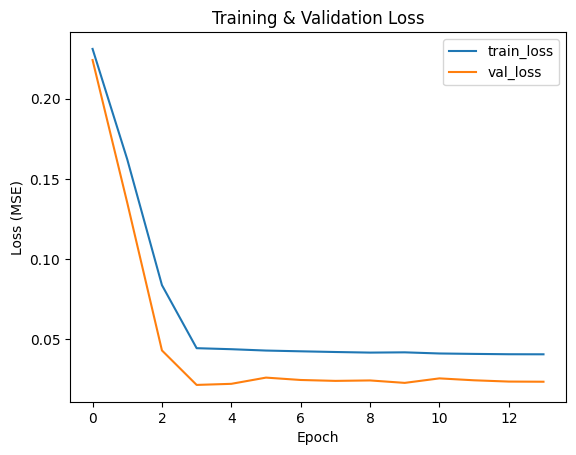

In [107]:
# -------------------------------
# Plot training curves
# -------------------------------
plt.plot(history['train_loss'], label='train_loss')
plt.plot(history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.title('Training & Validation Loss')
plt.show()

## Prediction

In [109]:
# -------------------------------
# Evaluation on Test Set
# -------------------------------
@torch.no_grad()
def predict_all(model, loader, device="cpu"):
    model.eval()
    preds, ys = [], []
    for xb, yb in loader:
        xb = xb.to(device)
        out = model(xb.unsqueeze(0)).cpu().numpy()
        preds.append(out)
        ys.append(yb.numpy())
    return np.vstack(preds), np.vstack(ys)

y_pred_test, y_true_test = predict_all(model, test_loader)
y_pred_inv = scaler.inverse_transform(y_pred_test)
y_true_inv = scaler.inverse_transform(y_true_test)

mse = mean_squared_error(y_true_inv, y_pred_inv)
rmse = math.sqrt(mse)
r2 = r2_score(y_true_inv, y_pred_inv)
print(f"Test MSE: {mse:.4f} | RMSE: {rmse:.4f} | R^2: {r2:.4f}")


Test MSE: 20047932.0000 | RMSE: 4477.4917 | R^2: -0.3967


## Plot prediction

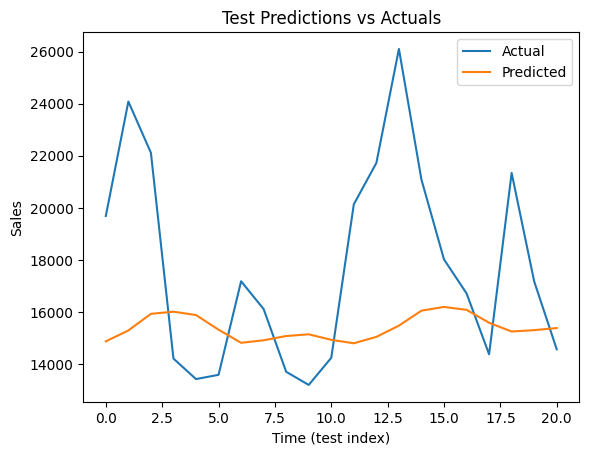

In [110]:
# -------------------------------
# Plot predictions
# -------------------------------
plt.plot(y_true_inv, label='Actual')
plt.plot(y_pred_inv, label='Predicted')
plt.xlabel('Time (test index)')
plt.ylabel('Sales')
plt.legend()
plt.title('Test Predictions vs Actuals')
plt.show()

## Forcasting

In [112]:
# -------------------------------
# One-step ahead forecast
# -------------------------------
X_input = X_train_full[-1:,:,:]
X_input_t = torch.from_numpy(X_input).float()
with torch.no_grad():
    pred_scaled = model(X_input_t.unsqueeze(0)).cpu().numpy()
pred_value = scaler.inverse_transform(pred_scaled)[0,0]
print("One-step ahead prediction based on last training window:", pred_value)


One-step ahead prediction based on last training window: 14713.165
